# Previsão de Preços de Fechamento no Mercado Acionário com a Utilização de Rede Neural Recorrente

#### Aluno: [Pedro Marques](https://github.com/pedromq)
#### Orientador: [Leonardo Forero Mendonza](https://github.com/leofome8)

Trabalho apresentado ao curso [BI MASTER](https://ica.puc-rio.ai/bi-master) como pré-requisito para conclusão de curso e obtenção de crédito na disciplina "Projetos de Sistemas Inteligentes de Apoio à Decisão".

---

### Instalação do pacote [investpy](https://github.com/alvarobartt/investpy)
Utilizado para aquisição dos dados do mercado acionário, atráves do portal financeiro [Investing.com](https://investing.com)

In [1]:
!pip install investpy

### Importação dos pacotes utilizados

In [2]:
import investpy
import datetime
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Nadam, Adam, Adadelta, Adagrad
from statsmodels.tsa.stattools import adfuller
from tech_analysis import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Definição de variáveis do investpy

In [3]:
stock = 'PETR4' # ticker da ação que se deseja utilizar
country = 'Brazil' # país da bolsa de valores que se deseja utilizar
n_last_days = 5 * 365 # número de dias corridos que retroage a aquisição de dados

to_date = datetime.date(2021, 10, 8) # aquisição de dados até a data de 08/Out/2021
from_date = to_date - datetime.timedelta(days=n_last_days) # aquisição de dados a partir de n_last_days antes de 08/Out/2021

### Definição de variáveis para seleção dos conjuntos de treino, teste e janela móvel de entrada na rede neural

In [4]:
test_days = 15 # tamanho da sequência que será utilizada como teste e se deseja prever, em dias úteis
window = 12 # tamanho da janela móvel utilizada na entrada da RNN, em dias úteis

### Definição de variáveis e callbacks para RNN

In [5]:
neurons = 100
dropout = 0.3
opt = Nadam()
loss = 'mape'
epochs = 2000
batch_size = 32
validation_split = 0.1

es = EarlyStopping(monitor = 'loss', patience=75)
filepath_Alt_A = 'best_model_Alt_A.hdf5'
filepath_Alt_B = 'best_model_Alt_B.hdf5'
filepath_Alt_C1 = 'best_model_Alt_C1.hdf5'
filepath_Alt_C2 = 'best_model_Alt_C2.hdf5'
filepath_Alt_D = 'best_model_Alt_D.hdf5'
cp_Alt_A = ModelCheckpoint(filepath_Alt_A, monitor = 'loss', save_best_only= True, mode='min')
cp_Alt_B = ModelCheckpoint(filepath_Alt_B, monitor = 'loss', save_best_only= True, mode='min')
cp_Alt_C1 = ModelCheckpoint(filepath_Alt_C1, monitor = 'loss', save_best_only= True, mode='min')
cp_Alt_C2 = ModelCheckpoint(filepath_Alt_C2, monitor = 'loss', save_best_only= True, mode='min')
cp_Alt_D = ModelCheckpoint(filepath_Alt_D, monitor = 'loss', save_best_only= True, mode='min')

### Aquisição de dados

In [6]:
df = investpy.get_stock_historical_data(stock=stock,
                                        country=country,
                                        from_date=from_date.strftime('%d/%m/%Y'),
                                        to_date=to_date.strftime('%d/%m/%Y'))

In [7]:
df.tail(10)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2021-09-27,27.14,27.46,26.50,27.14,88965800,BRL
2021-09-28,27.19,27.89,26.72,26.96,117496304,BRL
2021-09-29,27.21,27.53,26.82,27.39,58554100,BRL
2021-09-30,27.53,27.58,27.17,27.23,65448700,BRL
2021-10-01,27.12,28.00,27.07,28.00,60610000,BRL
2021-10-04,27.76,28.81,27.72,28.79,106564496,BRL
2021-10-05,29.00,29.47,28.90,29.42,99460000,BRL
2021-10-06,28.95,29.17,28.47,28.64,84203000,BRL
2021-10-07,28.70,28.98,28.25,28.60,60190700,BRL


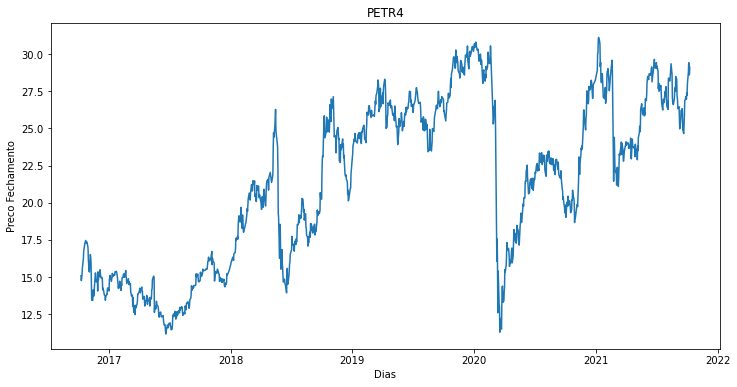

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.xlabel("Dias")
plt.ylabel("Preco Fechamento")
plt.title(stock)
plt.show()

### Inclusão de indicadores de análise técnica no dataframe

In [9]:
df['rsi'] = rsi(df)
df['williams'] = williams(df)
df['stoK'], df['stoD'] = stochastic(df)

In [10]:
df.head(20)

,Open,High,Low,Close,Volume,Currency,rsi,williams,stoK,stoD
Date,,,,,,,,,,
2016-10-10,14.89,15.13,14.88,15.09,38276900,BRL,NaN,NaN,NaN,NaN
2016-10-11,14.98,15.02,14.67,14.76,67922200,BRL,NaN,NaN,NaN,NaN
2016-10-13,14.57,15.18,14.42,15.12,57948800,BRL,NaN,NaN,NaN,NaN
2016-10-14,15.36,15.63,15.33,15.60,65860200,BRL,NaN,NaN,NaN,NaN
2016-10-17,15.58,16.21,15.42,16.21,75002000,BRL,NaN,NaN,NaN,NaN
2016-10-18,16.51,16.92,16.48,16.71,76995000,BRL,NaN,NaN,NaN,NaN
2016-10-19,17.00,17.07,16.64,16.90,65212400,BRL,NaN,NaN,NaN,NaN
2016-10-20,16.61,17.02,16.52,17.02,62901500,BRL,NaN,NaN,NaN,NaN
2016-10-21,16.93,17.35,16.77,17.22,47961800,BRL,NaN,NaN,NaN,NaN


In [11]:
# retira as linhas com NaN geradas a partir do cálculo dos indicadores de análise técnica
df.dropna(inplace=True)
df.drop(columns = ['Currency'], inplace=True)

### Teste de Dickey-Fuller aumentado

In [12]:
for col in df.columns:
  print(f'\nColuna: {col}')
  result = adfuller(df.loc[:, col])
  print('ADF Statistic: {}'.format(result[0]))
  print('p-value: {}'.format(result[1]))
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
  print('\n---')


Coluna: Open
ADF Statistic: -2.4567129626024236
p-value: 0.1263648016161365
Critical Values:
	1%: -3.4357569339190457
	5%: -2.863927640806119
	10%: -2.5680412191887507

---

Coluna: High
ADF Statistic: -2.0523262905695616
p-value: 0.2641111660913035
Critical Values:
	1%: -3.4357929374222222
	5%: -2.86394352510997
	10%: -2.5680496786183373

---

Coluna: Low
ADF Statistic: -2.4214959966622844
p-value: 0.13576100587280426
Critical Values:
	1%: -3.435752466943879
	5%: -2.8639256700182405
	10%: -2.5680401696175466

---

Coluna: Close
ADF Statistic: -2.3755662134879088
p-value: 0.14875174069426284
Critical Values:
	1%: -3.435752466943879
	5%: -2.8639256700182405
	10%: -2.5680401696175466

---

Coluna: Volume
ADF Statistic: -5.735672755271231
p-value: 6.447018971188418e-07
Critical Values:
	1%: -3.4357569339190457
	5%: -2.863927640806119
	10%: -2.5680412191887507

---

Coluna: rsi
ADF Statistic: -6.556262590371728
p-value: 8.601386715428683e-09
Critical Values:
	1%: -3.435783891669927
	5%: -

### Separação dos conjuntos de treino, conforme alternativas, e teste
* Alternativa A - 1 dimensão - Preço de fechamento diário
* Alternativa B - 2 dimensões - Preço de fechamento diário e Volume diário negociado
* Alternativa C1 - 3 dimensões - Preço de fechamento diário, Volume diário negociado e Índice de Força Relativa
* Alternativa C2 - 3 dimensões - Preço de fechamento diário, Volume diário negociado e Williams %R
* Alternativa D - 4 dimensões - Preço de fechamento diário, Preço de abertura diário, Preço máximo diário e Preço mínimo diário

---



In [13]:
# separação do conjunto de teste
test_set = df.iloc[-test_days:, [3]].values

# separação dos conjuntos de treino conforme alternativas (não incluem o conjunto de teste contra o qual as previsões serão comparadas)
training_set_Alt_A = df.iloc[:-test_days, [3]].values
training_set_Alt_B = df.iloc[:-test_days, [3, 4]].values
training_set_Alt_C1 = df.iloc[:-test_days, [3, 4, 5]].values
training_set_Alt_C2 = df.iloc[:-test_days, [3, 4, 6]].values
training_set_Alt_D = df.iloc[:-test_days, [3, 0, 1, 2]].values

### Normalização

In [14]:
scaler_Alt_A = StandardScaler()
scaler_Alt_B = StandardScaler()
scaler_Alt_C1 = StandardScaler()
scaler_Alt_C2 = StandardScaler()
scaler_Alt_D = StandardScaler()

training_set_Alt_A_scaled = scaler_Alt_A.fit_transform(training_set_Alt_A)
training_set_Alt_B_scaled = scaler_Alt_B.fit_transform(training_set_Alt_B)
training_set_Alt_C1_scaled = scaler_Alt_C1.fit_transform(training_set_Alt_C1)
training_set_Alt_C2_scaled = scaler_Alt_C2.fit_transform(training_set_Alt_C2)
training_set_Alt_D_scaled = scaler_Alt_D.fit_transform(training_set_Alt_D)

### Preparação dos conjuntos de treino para entrada no modelo

In [15]:
def split_train (training_set_scaled):
  trainSize = len(training_set_scaled)
  X_train = []
  y_train = []
  for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, :])
    y_train.append(training_set_scaled[i, :])
  X_train, y_train = np.array(X_train), np.array(y_train)
  return X_train, y_train

In [16]:
X_train_Alt_A, y_train_Alt_A = split_train(training_set_Alt_A_scaled)
X_train_Alt_B, y_train_Alt_B = split_train(training_set_Alt_B_scaled)
X_train_Alt_C1, y_train_Alt_C1 = split_train(training_set_Alt_C1_scaled)
X_train_Alt_C2, y_train_Alt_C2 = split_train(training_set_Alt_C2_scaled)
X_train_Alt_D, y_train_Alt_D = split_train(training_set_Alt_D_scaled)

### Alternativa A - Configuração da RNN

In [17]:
# Inicializar a RNN
model_Alt_A = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
model_Alt_A.add(LSTM(units = neurons, return_sequences = True, input_shape = (X_train_Alt_A.shape[1], X_train_Alt_A.shape[2])))
model_Alt_A.add(Dropout(dropout))
 
# Adicionar a segunda camada LSTM e Dropout
model_Alt_A.add(LSTM(units = neurons, return_sequences = True))
model_Alt_A.add(Dropout(dropout))

# Adicionar a terceira camada LSTM e Dropout
model_Alt_A.add(LSTM(units = neurons))
model_Alt_A.add(Dropout(dropout))
 
# camada de saída
model_Alt_A.add(Dense(units = y_train_Alt_A.shape[1]))
 
# Compilar a rede
model_Alt_A.compile(optimizer = opt, loss = loss)

# Visualizar a rede
model_Alt_A.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 12, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 100)           80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

### Alternativa A - Treino do modelo

In [18]:
history = model_Alt_A.fit(X_train_Alt_A, y_train_Alt_A, validation_split = validation_split, epochs = epochs, batch_size = batch_size, callbacks = [es, cp_Alt_A])

Epoch 1/2000
34/34 [==============================] - 8s 47ms/step - loss: 87.8960 - val_loss: 40.6975
Epoch 2/2000
34/34 [==============================] - 0s 11ms/step - loss: 80.3810 - val_loss: 63.0898
Epoch 3/2000
34/34 [==============================] - 0s 11ms/step - loss: 75.9333 - val_loss: 58.5709
Epoch 4/2000
34/34 [==============================] - 0s 11ms/step - loss: 73.7311 - val_loss: 50.4830
Epoch 5/2000
34/34 [==============================] - 0s 12ms/step - loss: 79.8959 - val_loss: 69.1768
Epoch 6/2000
34/34 [==============================] - 0s 11ms/step - loss: 74.3740 - val_loss: 39.7670
Epoch 7/2000
34/34 [==============================] - 0s 12ms/step - loss: 75.2052 - val_loss: 63.9211
Epoch 8/2000
34/34 [==============================] - 0s 12ms/step - loss: 69.4343 - val_loss: 63.6954
Epoch 9/2000
34/34 [==============================] - 0s 12ms/step - loss: 72.6124 - val_loss: 71.3575
Epoch 10/2000
34/34 [==============================] - 0s 12ms/step - los

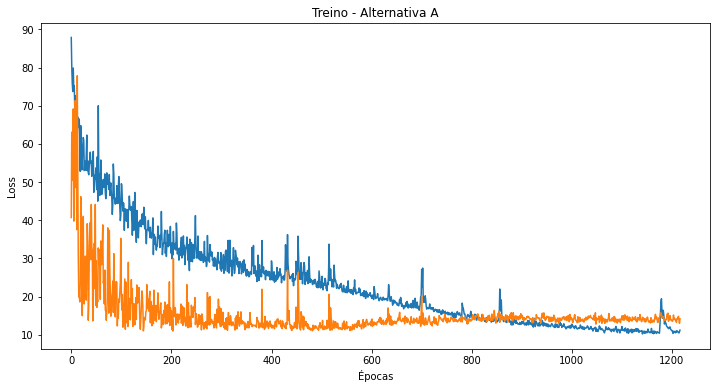

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Treino - Alternativa A')
plt.show()

### Alternativa B - Configuração da RNN

In [20]:
# Inicializar a RNN
model_Alt_B = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
model_Alt_B.add(LSTM(units = neurons, return_sequences = True, input_shape = (X_train_Alt_B.shape[1], X_train_Alt_B.shape[2])))
model_Alt_B.add(Dropout(dropout))
 
# Adicionar a segunda camada LSTM e Dropout
model_Alt_B.add(LSTM(units = neurons, return_sequences = True))
model_Alt_B.add(Dropout(dropout))

# Adicionar a terceira camada LSTM e Dropout
model_Alt_B.add(LSTM(units = neurons))
model_Alt_B.add(Dropout(dropout))
 
# camada de saída
model_Alt_B.add(Dense(units = y_train_Alt_B.shape[1]))
 
# Compilar a rede
model_Alt_B.compile(optimizer = opt, loss = loss)

# Visualizar a rede
model_Alt_B.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 100)           41200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 100)           80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

### Alternativa B - Treino do modelo

In [21]:
history = model_Alt_B.fit(X_train_Alt_B, y_train_Alt_B, validation_split = validation_split, epochs = epochs, batch_size = batch_size, callbacks = [es, cp_Alt_B])

Epoch 1/2000
34/34 [==============================] - 7s 45ms/step - loss: 112.7755 - val_loss: 99.1382
Epoch 2/2000
34/34 [==============================] - 0s 11ms/step - loss: 104.8244 - val_loss: 108.5349
Epoch 3/2000
34/34 [==============================] - 0s 12ms/step - loss: 92.3266 - val_loss: 92.2097
Epoch 4/2000
34/34 [==============================] - 0s 12ms/step - loss: 97.5247 - val_loss: 95.3397
Epoch 5/2000
34/34 [==============================] - 0s 12ms/step - loss: 94.0917 - val_loss: 91.0442
Epoch 6/2000
34/34 [==============================] - 0s 11ms/step - loss: 86.2756 - val_loss: 92.6312
Epoch 7/2000
34/34 [==============================] - 0s 12ms/step - loss: 88.9003 - val_loss: 94.4864
Epoch 8/2000
34/34 [==============================] - 0s 11ms/step - loss: 90.8815 - val_loss: 91.8306
Epoch 9/2000
34/34 [==============================] - 0s 11ms/step - loss: 87.3997 - val_loss: 90.0759
Epoch 10/2000
34/34 [==============================] - 0s 11ms/step - 

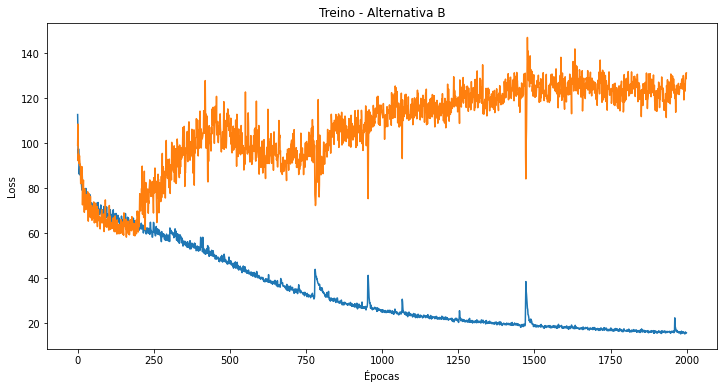

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Treino - Alternativa B')
plt.show()

### Alternativa C1 - Configuração da RNN

In [23]:
# Inicializar a RNN
model_Alt_C1 = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
model_Alt_C1.add(LSTM(units = neurons, return_sequences = True, input_shape = (X_train_Alt_C1.shape[1], X_train_Alt_C1.shape[2])))
model_Alt_C1.add(Dropout(dropout))
 
# Adicionar a segunda camada LSTM e Dropout
model_Alt_C1.add(LSTM(units = neurons, return_sequences = True))
model_Alt_C1.add(Dropout(dropout))

# Adicionar a terceira camada LSTM e Dropout
model_Alt_C1.add(LSTM(units = neurons))
model_Alt_C1.add(Dropout(dropout))
 
# camada de saída
model_Alt_C1.add(Dense(units = y_train_Alt_C1.shape[1]))
 
# Compilar a rede
model_Alt_C1.compile(optimizer = opt, loss = loss)

# Visualizar a rede
model_Alt_C1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 12, 100)           41600     
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 12, 100)           80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 100)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

### Alternativa C1 - Treino do modelo

In [24]:
history = model_Alt_C1.fit(X_train_Alt_C1, y_train_Alt_C1, validation_split = validation_split, epochs = epochs, batch_size = batch_size, callbacks = [es, cp_Alt_C1])

Epoch 1/2000
34/34 [==============================] - 7s 46ms/step - loss: 135.8107 - val_loss: 108.4768
Epoch 2/2000
34/34 [==============================] - 0s 11ms/step - loss: 118.8341 - val_loss: 99.6469
Epoch 3/2000
34/34 [==============================] - 0s 11ms/step - loss: 112.4201 - val_loss: 98.0280
Epoch 4/2000
34/34 [==============================] - 0s 12ms/step - loss: 106.5735 - val_loss: 101.1729
Epoch 5/2000
34/34 [==============================] - 0s 11ms/step - loss: 103.2703 - val_loss: 98.6968
Epoch 6/2000
34/34 [==============================] - 0s 11ms/step - loss: 103.6369 - val_loss: 99.8559
Epoch 7/2000
34/34 [==============================] - 0s 12ms/step - loss: 103.3051 - val_loss: 97.8329
Epoch 8/2000
34/34 [==============================] - 0s 11ms/step - loss: 100.3411 - val_loss: 93.6822
Epoch 9/2000
34/34 [==============================] - 0s 12ms/step - loss: 102.3695 - val_loss: 104.2569
Epoch 10/2000
34/34 [==============================] - 0s 11m

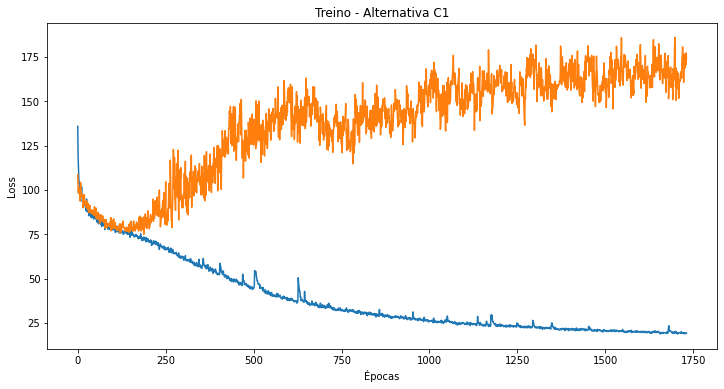

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Treino - Alternativa C1')
plt.show()

### Alternativa C2 - Configuração da RNN

In [26]:
# Inicializar a RNN
model_Alt_C2 = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
model_Alt_C2.add(LSTM(units = neurons, return_sequences = True, input_shape = (X_train_Alt_C2.shape[1], X_train_Alt_C2.shape[2])))
model_Alt_C2.add(Dropout(dropout))
 
# Adicionar a segunda camada LSTM e Dropout
model_Alt_C2.add(LSTM(units = neurons, return_sequences = True))
model_Alt_C2.add(Dropout(dropout))

# Adicionar a terceira camada LSTM e Dropout
model_Alt_C2.add(LSTM(units = neurons))
model_Alt_C2.add(Dropout(dropout))
 
# camada de saída
model_Alt_C2.add(Dense(units = y_train_Alt_C2.shape[1]))
 
# Compilar a rede
model_Alt_C2.compile(optimizer = opt, loss = loss)

# Visualizar a rede
model_Alt_C2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 12, 100)           41600     
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 100)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 12, 100)           80400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 12, 100)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

### Alternativa C2 - Treino do modelo

In [27]:
history = model_Alt_C2.fit(X_train_Alt_C2, y_train_Alt_C2, validation_split = validation_split, epochs = epochs, batch_size = batch_size, callbacks = [es, cp_Alt_C2])

Epoch 1/2000
34/34 [==============================] - 7s 47ms/step - loss: 173.2747 - val_loss: 115.7639
Epoch 2/2000
34/34 [==============================] - 0s 12ms/step - loss: 145.8226 - val_loss: 114.3605
Epoch 3/2000
34/34 [==============================] - 0s 12ms/step - loss: 157.7302 - val_loss: 97.5230
Epoch 4/2000
34/34 [==============================] - 0s 12ms/step - loss: 131.7260 - val_loss: 96.1045
Epoch 5/2000
34/34 [==============================] - 0s 12ms/step - loss: 121.2057 - val_loss: 92.1513
Epoch 6/2000
34/34 [==============================] - 0s 12ms/step - loss: 122.2038 - val_loss: 93.6970
Epoch 7/2000
34/34 [==============================] - 0s 12ms/step - loss: 116.0030 - val_loss: 92.6894
Epoch 8/2000
34/34 [==============================] - 0s 12ms/step - loss: 113.8587 - val_loss: 94.7314
Epoch 9/2000
34/34 [==============================] - 0s 12ms/step - loss: 120.8950 - val_loss: 93.1929
Epoch 10/2000
34/34 [==============================] - 0s 11ms

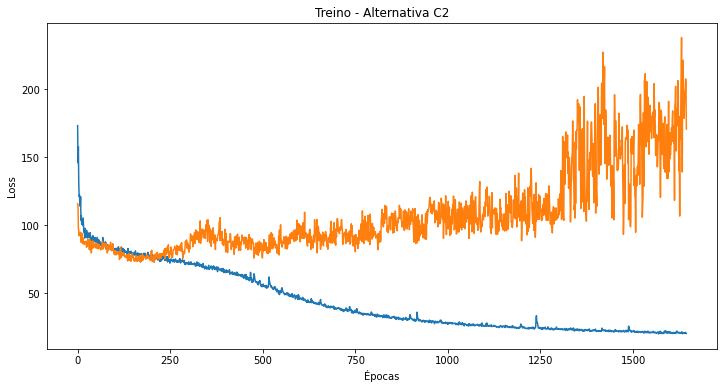

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Treino - Alternativa C2')
plt.show()

### Alternativa D - Configuração da RNN

In [29]:
# Inicializar a RNN
model_Alt_D = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
model_Alt_D.add(LSTM(units = neurons, return_sequences = True, input_shape = (X_train_Alt_D.shape[1], X_train_Alt_D.shape[2])))
model_Alt_D.add(Dropout(dropout))
 
# Adicionar a segunda camada LSTM e Dropout
model_Alt_D.add(LSTM(units = neurons, return_sequences = True))
model_Alt_D.add(Dropout(dropout))

# Adicionar a terceira camada LSTM e Dropout
model_Alt_D.add(LSTM(units = neurons))
model_Alt_D.add(Dropout(dropout))
 
# camada de saída
model_Alt_D.add(Dense(units = y_train_Alt_D.shape[1]))
 
# Compilar a rede
model_Alt_D.compile(optimizer = opt, loss = loss)

# Visualizar a rede
model_Alt_D.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 12, 100)           42000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 12, 100)           80400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 12, 100)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                

### Alternativa D - Treino do modelo

In [30]:
history = model_Alt_D.fit(X_train_Alt_D, y_train_Alt_D, validation_split = validation_split, epochs = epochs, batch_size = batch_size, callbacks = [es, cp_Alt_D])

Epoch 1/2000
34/34 [==============================] - 7s 48ms/step - loss: 124.9788 - val_loss: 65.4387
Epoch 2/2000
34/34 [==============================] - 0s 12ms/step - loss: 210.1252 - val_loss: 38.6616
Epoch 3/2000
34/34 [==============================] - 0s 12ms/step - loss: 104.0943 - val_loss: 42.7272
Epoch 4/2000
34/34 [==============================] - 0s 12ms/step - loss: 75.5044 - val_loss: 23.1164
Epoch 5/2000
34/34 [==============================] - 0s 11ms/step - loss: 72.5948 - val_loss: 31.7544
Epoch 6/2000
34/34 [==============================] - 0s 12ms/step - loss: 77.3127 - val_loss: 37.8843
Epoch 7/2000
34/34 [==============================] - 0s 12ms/step - loss: 59.0937 - val_loss: 33.7642
Epoch 8/2000
34/34 [==============================] - 0s 12ms/step - loss: 60.9059 - val_loss: 25.6106
Epoch 9/2000
34/34 [==============================] - 0s 12ms/step - loss: 57.5472 - val_loss: 25.9169
Epoch 10/2000
34/34 [==============================] - 0s 12ms/step - 

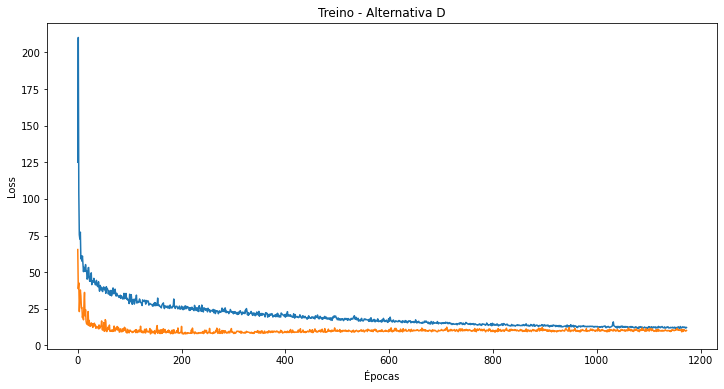

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Treino - Alternativa D')
plt.show()

### Carregando os modelos treinados

In [32]:
model_Alt_A.load_weights('best_model_Alt_A.hdf5')
model_Alt_B.load_weights('best_model_Alt_B.hdf5')
model_Alt_C1.load_weights('best_model_Alt_C1.hdf5')
model_Alt_C2.load_weights('best_model_Alt_C2.hdf5')
model_Alt_D.load_weights('best_model_Alt_D.hdf5')

### Fazendo as previsões

In [33]:
# criação de um conjunto de entrada para a previsão
# este conjunto é retirado do último grupo de dados mas que não foi utilizado no treinamento

X_test_Alt_A = []
X_test_Alt_A.append(training_set_Alt_A_scaled[-window:, :])
X_test_Alt_A = np.array(X_test_Alt_A)

X_test_Alt_B = []
X_test_Alt_B.append(training_set_Alt_B_scaled[-window:, :])
X_test_Alt_B = np.array(X_test_Alt_B)

X_test_Alt_C1 = []
X_test_Alt_C1.append(training_set_Alt_C1_scaled[-window:, :])
X_test_Alt_C1 = np.array(X_test_Alt_C1)

X_test_Alt_C2 = []
X_test_Alt_C2.append(training_set_Alt_C2_scaled[-window:, :])
X_test_Alt_C2 = np.array(X_test_Alt_C2)

X_test_Alt_D = []
X_test_Alt_D.append(training_set_Alt_D_scaled[-window:, :])
X_test_Alt_D = np.array(X_test_Alt_D)

In [34]:
def prediction (model, X_test, scaler):
  predicted_set = np.array([])
  for i in range(len(test_set)):
    last_predicted_price = model.predict(X_test)
    predicted_set = np.append(predicted_set, scaler.inverse_transform(last_predicted_price))
    last_predicted_price = np.reshape(last_predicted_price, (1, last_predicted_price.shape[0], last_predicted_price.shape[1]))
    X_test = np.delete(X_test, 0, axis=1)
    X_test = np.hstack((X_test, last_predicted_price))
  return predicted_set

In [35]:
predicted_set_Alt_A = prediction(model_Alt_A, X_test_Alt_A, scaler_Alt_A)
predicted_set_Alt_B = prediction(model_Alt_B, X_test_Alt_B, scaler_Alt_B)
predicted_set_Alt_C1 = prediction(model_Alt_C1, X_test_Alt_C1, scaler_Alt_C1)
predicted_set_Alt_C2 = prediction(model_Alt_C2, X_test_Alt_C2, scaler_Alt_C2)
predicted_set_Alt_D = prediction(model_Alt_D, X_test_Alt_D, scaler_Alt_D)

In [36]:
predicted_set_Alt_A = predicted_set_Alt_A.reshape(-1, y_train_Alt_A.shape[1])
predicted_set_Alt_B = predicted_set_Alt_B.reshape(-1, y_train_Alt_B.shape[1])
predicted_set_Alt_C1 = predicted_set_Alt_C1.reshape(-1, y_train_Alt_C1.shape[1])
predicted_set_Alt_C2 = predicted_set_Alt_C2.reshape(-1, y_train_Alt_C2.shape[1])
predicted_set_Alt_D = predicted_set_Alt_D.reshape(-1, y_train_Alt_D.shape[1])

### Ajustando formato e invertendo a normalização TROCAR
Para inverter a normalização é necessário ajustar o formato para o mesmo utilizado na normalização (o mesmo número de dimensões), para isso foram concatenadas as previsões com arrays NaN

No fim são aproveitados os valores de previsão do preço de fechamento com a normalização invertida

In [37]:
predicted_set_Alt_A = predicted_set_Alt_A[:, 0]
predicted_set_Alt_B = predicted_set_Alt_B[:, 0]
predicted_set_Alt_C1 = predicted_set_Alt_C1[:, 0]
predicted_set_Alt_C2 = predicted_set_Alt_C2[:, 0]
predicted_set_Alt_D = predicted_set_Alt_D[:, 0]

### Alternativa A - Resultados

In [38]:
rmse = math.sqrt(mean_squared_error(test_set, predicted_set_Alt_A))
mape = np.mean(np.abs((test_set - predicted_set_Alt_A) / test_set)) * 100
mae = mean_absolute_error(test_set, predicted_set_Alt_A)
print(f'MAPE: {mape:.2f} %')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

MAPE: 16.89 %
RMSE: 5.05
MAE: 4.68


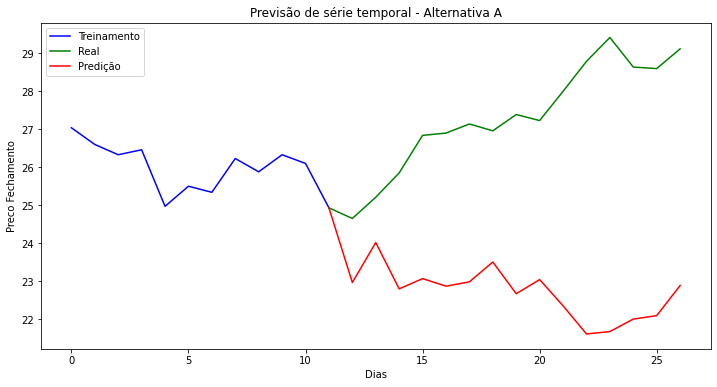

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(range(0, window), training_set_Alt_A[-window:, 0], color = 'blue', label = 'Treinamento')
plt.plot(range(window-1, window+len(test_set)), np.concatenate((training_set_Alt_A[-1, 0], test_set), axis=None), color = 'green', label = 'Real')
plt.plot(range(window-1, window+len(test_set)), np.concatenate((training_set_Alt_A[-1, 0], predicted_set_Alt_A), axis=None), color = 'red', label = 'Predição')
plt.title('Previsão de série temporal - Alternativa A')
plt.xlabel('Dias')
plt.ylabel('Preco Fechamento')
plt.legend()
plt.show()

### Alternativa B - Resultados

In [40]:
rmse = math.sqrt(mean_squared_error(test_set, predicted_set_Alt_B))
mape = np.mean(np.abs((test_set - predicted_set_Alt_B) / test_set)) * 100
mae = mean_absolute_error(test_set, predicted_set_Alt_B)
print(f'MAPE: {mape:.2f} %')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

MAPE: 30.43 %
RMSE: 9.26
MAE: 8.38


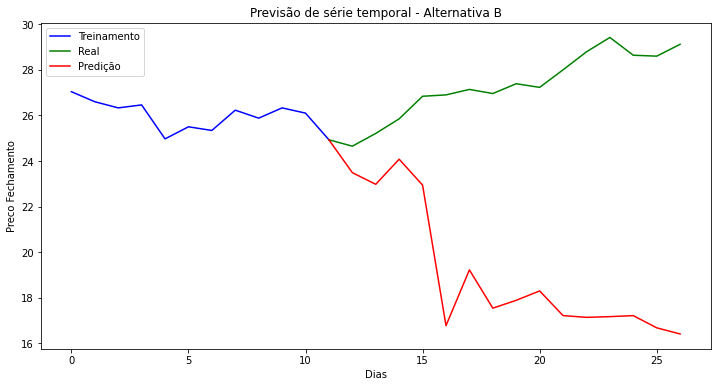

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(range(0, window), training_set_Alt_B[-window:, 0], color = 'blue', label = 'Treinamento')
plt.plot(range(window-1, window+len(test_set)), np.concatenate((training_set_Alt_B[-1, 0], test_set), axis=None), color = 'green', label = 'Real')
plt.plot(range(window-1, window+len(test_set)), np.concatenate((training_set_Alt_B[-1, 0], predicted_set_Alt_B), axis=None), color = 'red', label = 'Predição')
plt.title('Previsão de série temporal - Alternativa B')
plt.xlabel('Dias')
plt.ylabel('Preco Fechamento')
plt.legend()
#plt.savefig('predictions_training_test.svg')
plt.show()

### Alternativa C1 - Resultados

In [42]:
rmse = math.sqrt(mean_squared_error(test_set, predicted_set_Alt_C1))
mape = np.mean(np.abs((test_set - predicted_set_Alt_C1) / test_set)) * 100
mae = mean_absolute_error(test_set, predicted_set_Alt_C1)
print(f'MAPE: {mape:.2f} %')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

MAPE: 15.01 %
RMSE: 4.47
MAE: 4.17


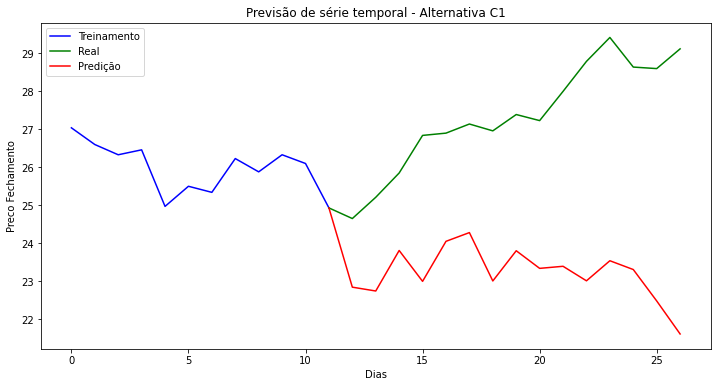

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(range(0, window), training_set_Alt_C1[-window:, 0], color = 'blue', label = 'Treinamento')
plt.plot(range(window-1, window+len(test_set)), np.concatenate((training_set_Alt_C1[-1, 0], test_set), axis=None), color = 'green', label = 'Real')
plt.plot(range(window-1, window+len(test_set)), np.concatenate((training_set_Alt_C1[-1, 0], predicted_set_Alt_C1), axis=None), color = 'red', label = 'Predição')
plt.title('Previsão de série temporal - Alternativa C1')
plt.xlabel('Dias')
plt.ylabel('Preco Fechamento')
plt.legend()
#plt.savefig('predictions_training_test.svg')
plt.show()

### Alternativa C2 - Resultados

In [44]:
rmse = math.sqrt(mean_squared_error(test_set, predicted_set_Alt_C2))
mape = np.mean(np.abs((test_set - predicted_set_Alt_C2) / test_set)) * 100
mae = mean_absolute_error(test_set, predicted_set_Alt_C2)
print(f'MAPE: {mape:.2f} %')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

MAPE: 15.23 %
RMSE: 4.76
MAE: 4.23


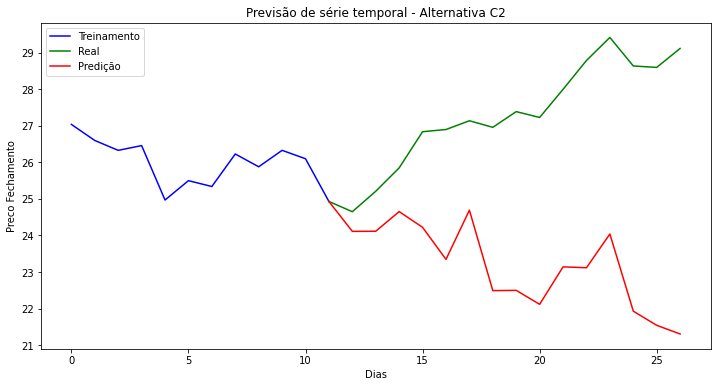

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(range(0, window), training_set_Alt_C2[-window:, 0], color = 'blue', label = 'Treinamento')
plt.plot(range(window-1, window+len(test_set)), np.concatenate((training_set_Alt_C2[-1, 0], test_set), axis=None), color = 'green', label = 'Real')
plt.plot(range(window-1, window+len(test_set)), np.concatenate((training_set_Alt_C2[-1, 0], predicted_set_Alt_C2), axis=None), color = 'red', label = 'Predição')
plt.title('Previsão de série temporal - Alternativa C2')
plt.xlabel('Dias')
plt.ylabel('Preco Fechamento')
plt.legend()
#plt.savefig('predictions_training_test.svg')
plt.show()

### Alternativa D - Resultados

In [46]:
rmse = math.sqrt(mean_squared_error(test_set, predicted_set_Alt_D))
mape = np.mean(np.abs((test_set - predicted_set_Alt_D) / test_set)) * 100
mae = mean_absolute_error(test_set, predicted_set_Alt_D)
print(f'MAPE: {mape:.2f} %')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

MAPE: 5.40 %
RMSE: 0.88
MAE: 0.71


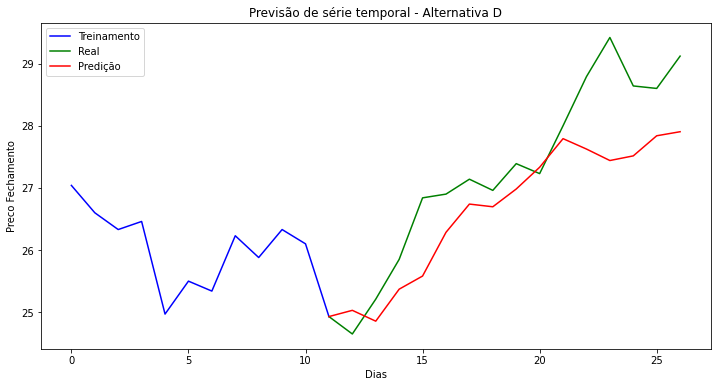

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(range(0, window), training_set_Alt_D[-window:, 0], color = 'blue', label = 'Treinamento')
plt.plot(range(window-1, window+len(test_set)), np.concatenate((training_set_Alt_D[-1, 0], test_set), axis=None), color = 'green', label = 'Real')
plt.plot(range(window-1, window+len(test_set)), np.concatenate((training_set_Alt_D[-1, 0], predicted_set_Alt_D), axis=None), color = 'red', label = 'Predição')
plt.title('Previsão de série temporal - Alternativa D')
plt.xlabel('Dias')
plt.ylabel('Preco Fechamento')
plt.legend()
#plt.savefig('predictions_training_test.svg')
plt.show()